In [34]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

Text(0, 0.5, '$CO_2$ ppm')

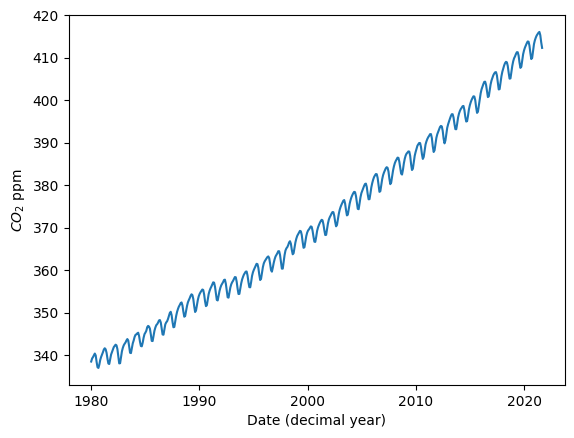

In [35]:
# importing the data
data = np.loadtxt("http://www.gatsby.ucl.ac.uk/teaching/courses/ml1/co2.txt")
trend = data[:, 4]
labels = data[:, 3]
time = data[:, 2]

plt.plot(time, labels, label="trend")
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")

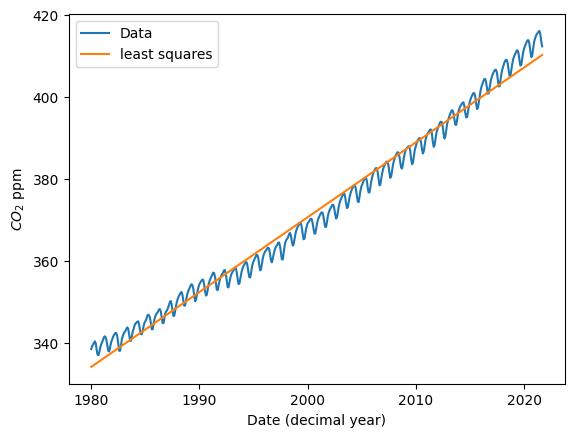

In [36]:
# we concatenate the data with a  vector of ones to multiply it with the posterior weight vector.
features = np.concatenate((time[:, None], np.ones((time.shape))[:, None]), axis=1)

# plot the data
plt.plot(time, labels, label="Data")

# Get least squares solution
w = np.linalg.pinv(features.T @ features) @ (features.T @ labels)
plt.plot(time, features @ w, label="least squares")

plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")
plt.legend()

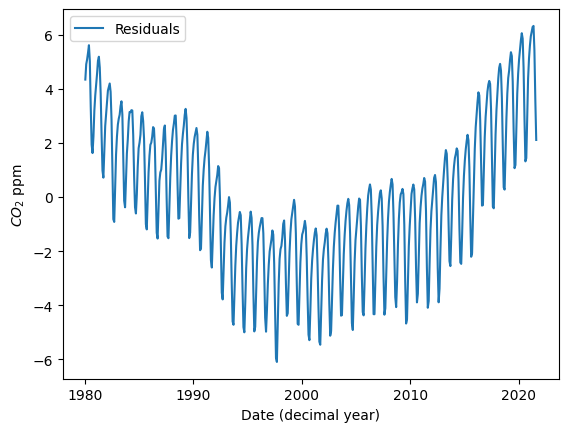

In [37]:
plt.plot(time, labels - (features@w), label="Residuals")
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")
plt.legend()

# Kernel Function

We define the kernel function as:
$$k(s, t) = \theta^2\Bigg[\underbrace{\exp\Big(-\frac{2\sin^2(\pi(s-t)/\tau)}{\sigma^2}\Big)}_{\text{Periodic distance kernel}}+\phi^2\underbrace{\exp\Big(-\frac{(s-t)^2}{2\
eta^2}\Big)}_{\text{Distance kernel}}\Bigg]+\underbrace{\zeta^2\delta_{s=t}}_{\text{Noise Kernel}}$$

In [38]:
def kernel_function(s, t):
    # small reshape hack to vectorise the operations
    s = s.reshape(-1, 1)
    t = t.reshape(1, -1)

    # parameters, found by experimentation.
    # Most implemntations of GPs would
    # have some optimisation routine to find these
    theta = 3
    tau = 1
    sigma = 2
    phi = 1
    eta = 6
    zeta = 0.1

    # Adding kernels together
    A = np.exp(-2 / (sigma**2) * (np.sin(np.pi * (s - t) / tau)) ** 2)
    B = phi**2 * np.exp(-((s - t) ** 2) / (2 * eta**2))
    C = zeta**2 * (s == t)

    cov_kernel = theta**2 * (A + B) + C

    return cov_kernel

Text(0, 0.5, '$CO_2$ ppm')

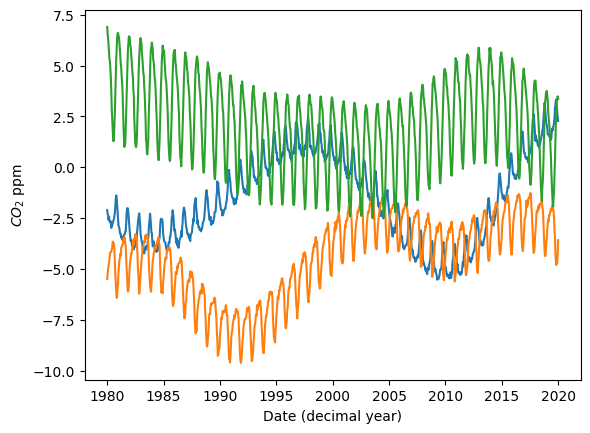

In [39]:
x = np.linspace(1980, 2020, 1000)

cov_kernel = kernel_function(x, x)
mean = np.zeros((cov_kernel.shape[0],))

# We can sample our GP function from a multivariate normal
samples = np.random.multivariate_normal(mean, cov_kernel, 3).T

plt.plot(x, samples)
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")

# Posterior Predictive Distribution
The posterior predictive distribution is defined as:
$$p(f_*|X_*, X, y) = \mathcal{N}(f_*|\mu_{po}, \Sigma_{po})\\
$$
And we define the mean and covariance as:
$$
\begin{aligned}
&\mu_{po} = K_{x^* x} K_{xx}^{-1} y\\
&\Sigma_{po} = K_{x^* x^*} - K_{x^* x} K_{xx}^{-1} K_{x x^*}
\end{aligned}
$$

Text(0, 0.5, '$CO_2$ ppm')

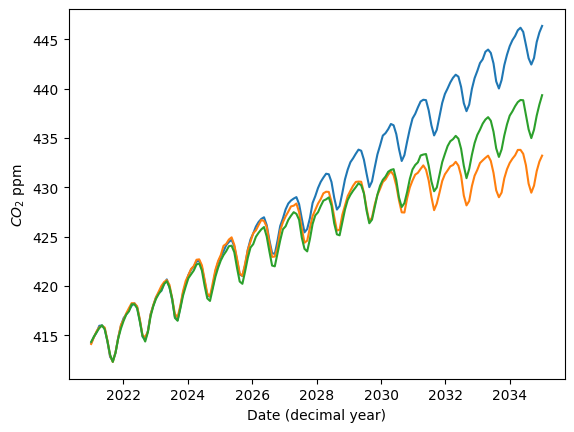

In [47]:
x = time
y = labels

features = np.concatenate((x[:, None], np.ones((x.shape))[:, None]), axis=1)
w = np.linalg.pinv(features.T @ features) @ (features.T @ y)
residuals = y - (features @ w)

# we want to model the c02 concentration to 2035
begin = 2021
end = 2035
x_test = np.linspace(begin, end, 12 * (end - begin))

# we calculated our posterior distribution conditioned on data
K = kernel_function(x_test, x_test)
Kxx = kernel_function(x, x)
Kx = kernel_function(x_test, x)
Kxx_inv = np.linalg.pinv(Kxx)

# mean and cov of conditioned GP
mean = Kx @ Kxx_inv @ residuals
Cov = K - Kx @ Kxx_inv @ Kx.T

# Get samples from the posterior
samples = np.random.multivariate_normal(mean, Cov, 3).T

features_new = np.concatenate(
    (x_test[:, None], np.ones((x_test.shape))[:, None]), axis=1
)
f = samples + (features_new @ w)[:, None]

# we plot the data with the extrapolation
plt.figure()
plt.plot(x_test, f)
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")

Text(0, 0.5, '$CO_2$ ppm')

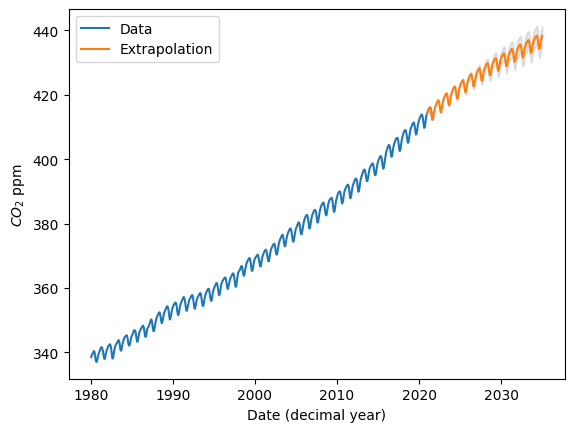

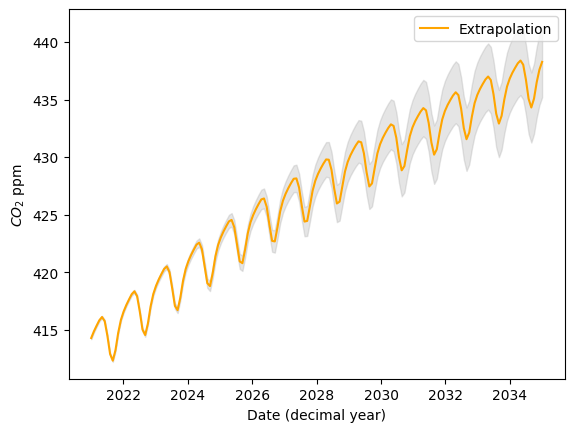

In [46]:
f_m = mean + features_new @ w

# for the error bars
std = np.diag(Cov).flatten() ** 0.5

# we plot the extrapolation only
plt.figure()
plt.plot(x, y, label="Data")
plt.plot(x_test, f_m, label="Extrapolation")
plt.fill_between(x_test, f_m + std, f_m - std, alpha=0.3, color="darkgrey")
plt.legend()
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")

# we plot the data with the extrapolation
plt.figure()
plt.plot(x_test, f_m, color="orange", label="Extrapolation")
plt.fill_between(x_test, f_m + std, f_m - std, alpha=0.3, color="darkgrey")
plt.legend()
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")